Fold 1/5 - R²: 0.8617
Fold 2/5 - R²: 0.8160
Fold 3/5 - R²: 0.8364
Fold 4/5 - R²: 0.7968
Fold 5/5 - R²: 0.7992

Cross-validation results:
Mean fold R²: 0.8220 (±0.0244)
Overall R² (all predictions): 0.8220

Saved DoR groups to ../data/cluster_results/regression_clusters.csv
Group sizes (based on predicted DoR):
Predicted DoR <= 0.35: 83
0.35 < Predicted DoR < 0.65: 293
Predicted DoR >= 0.65: 54


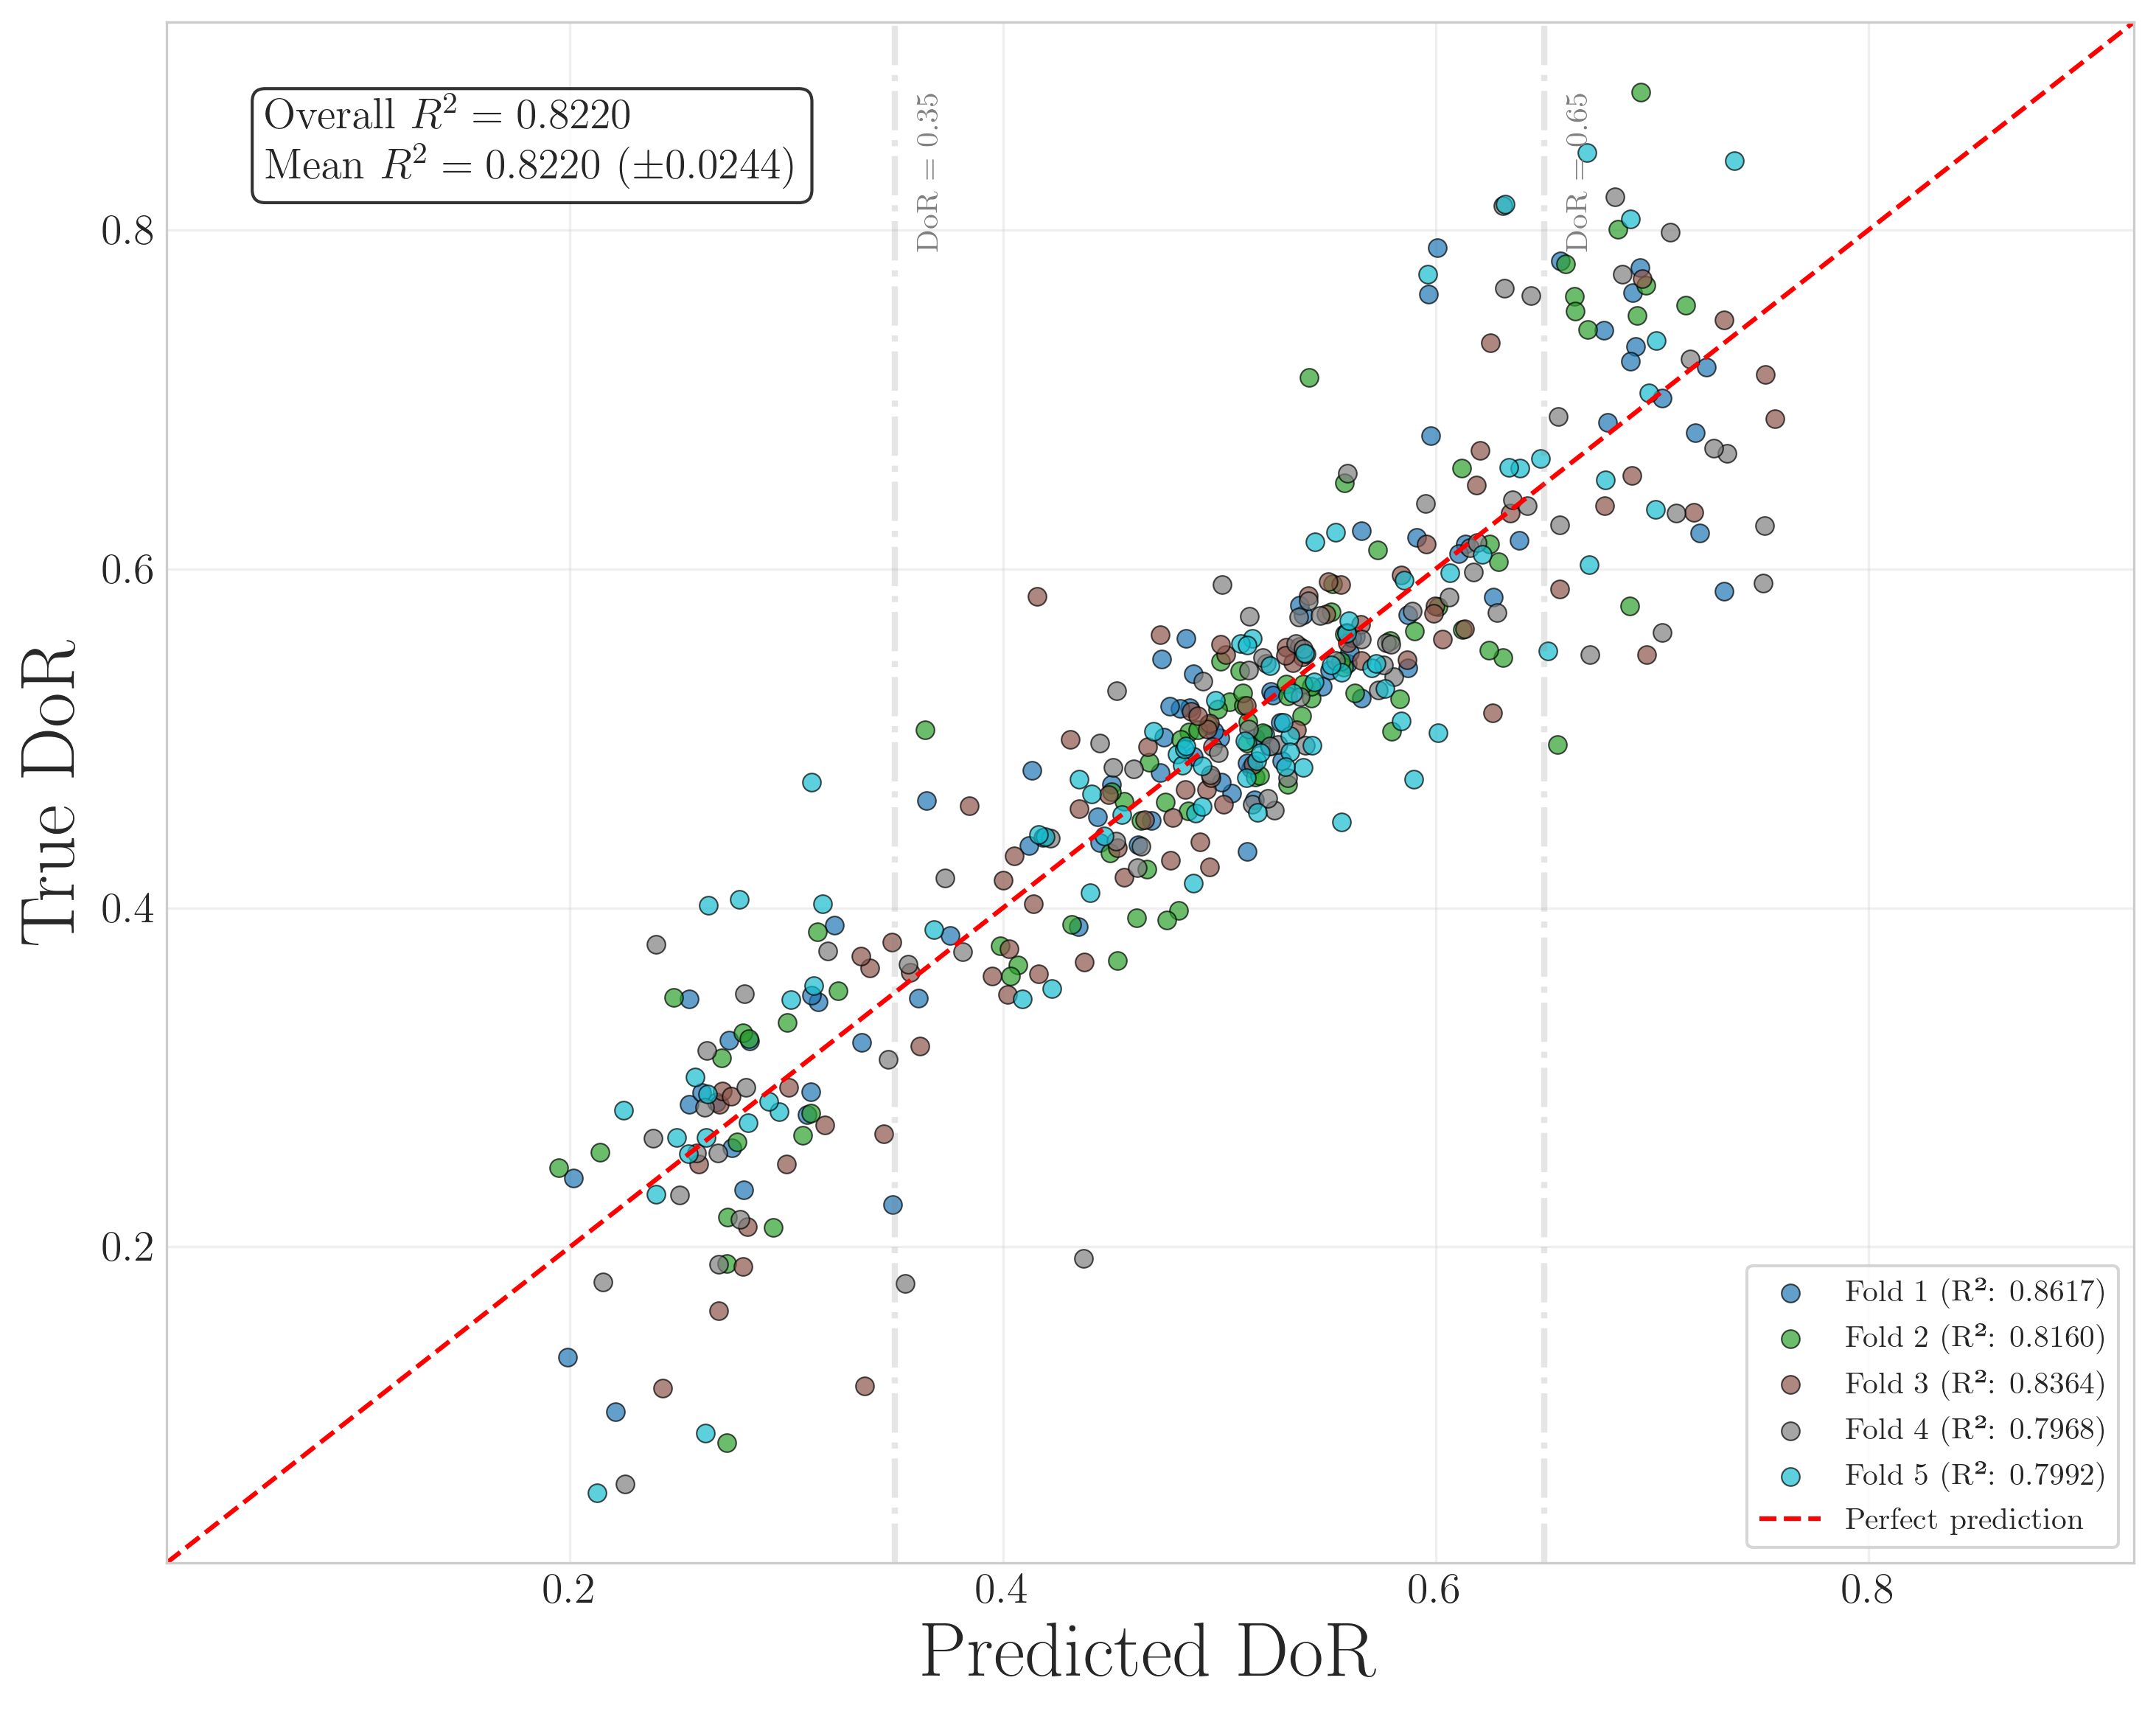

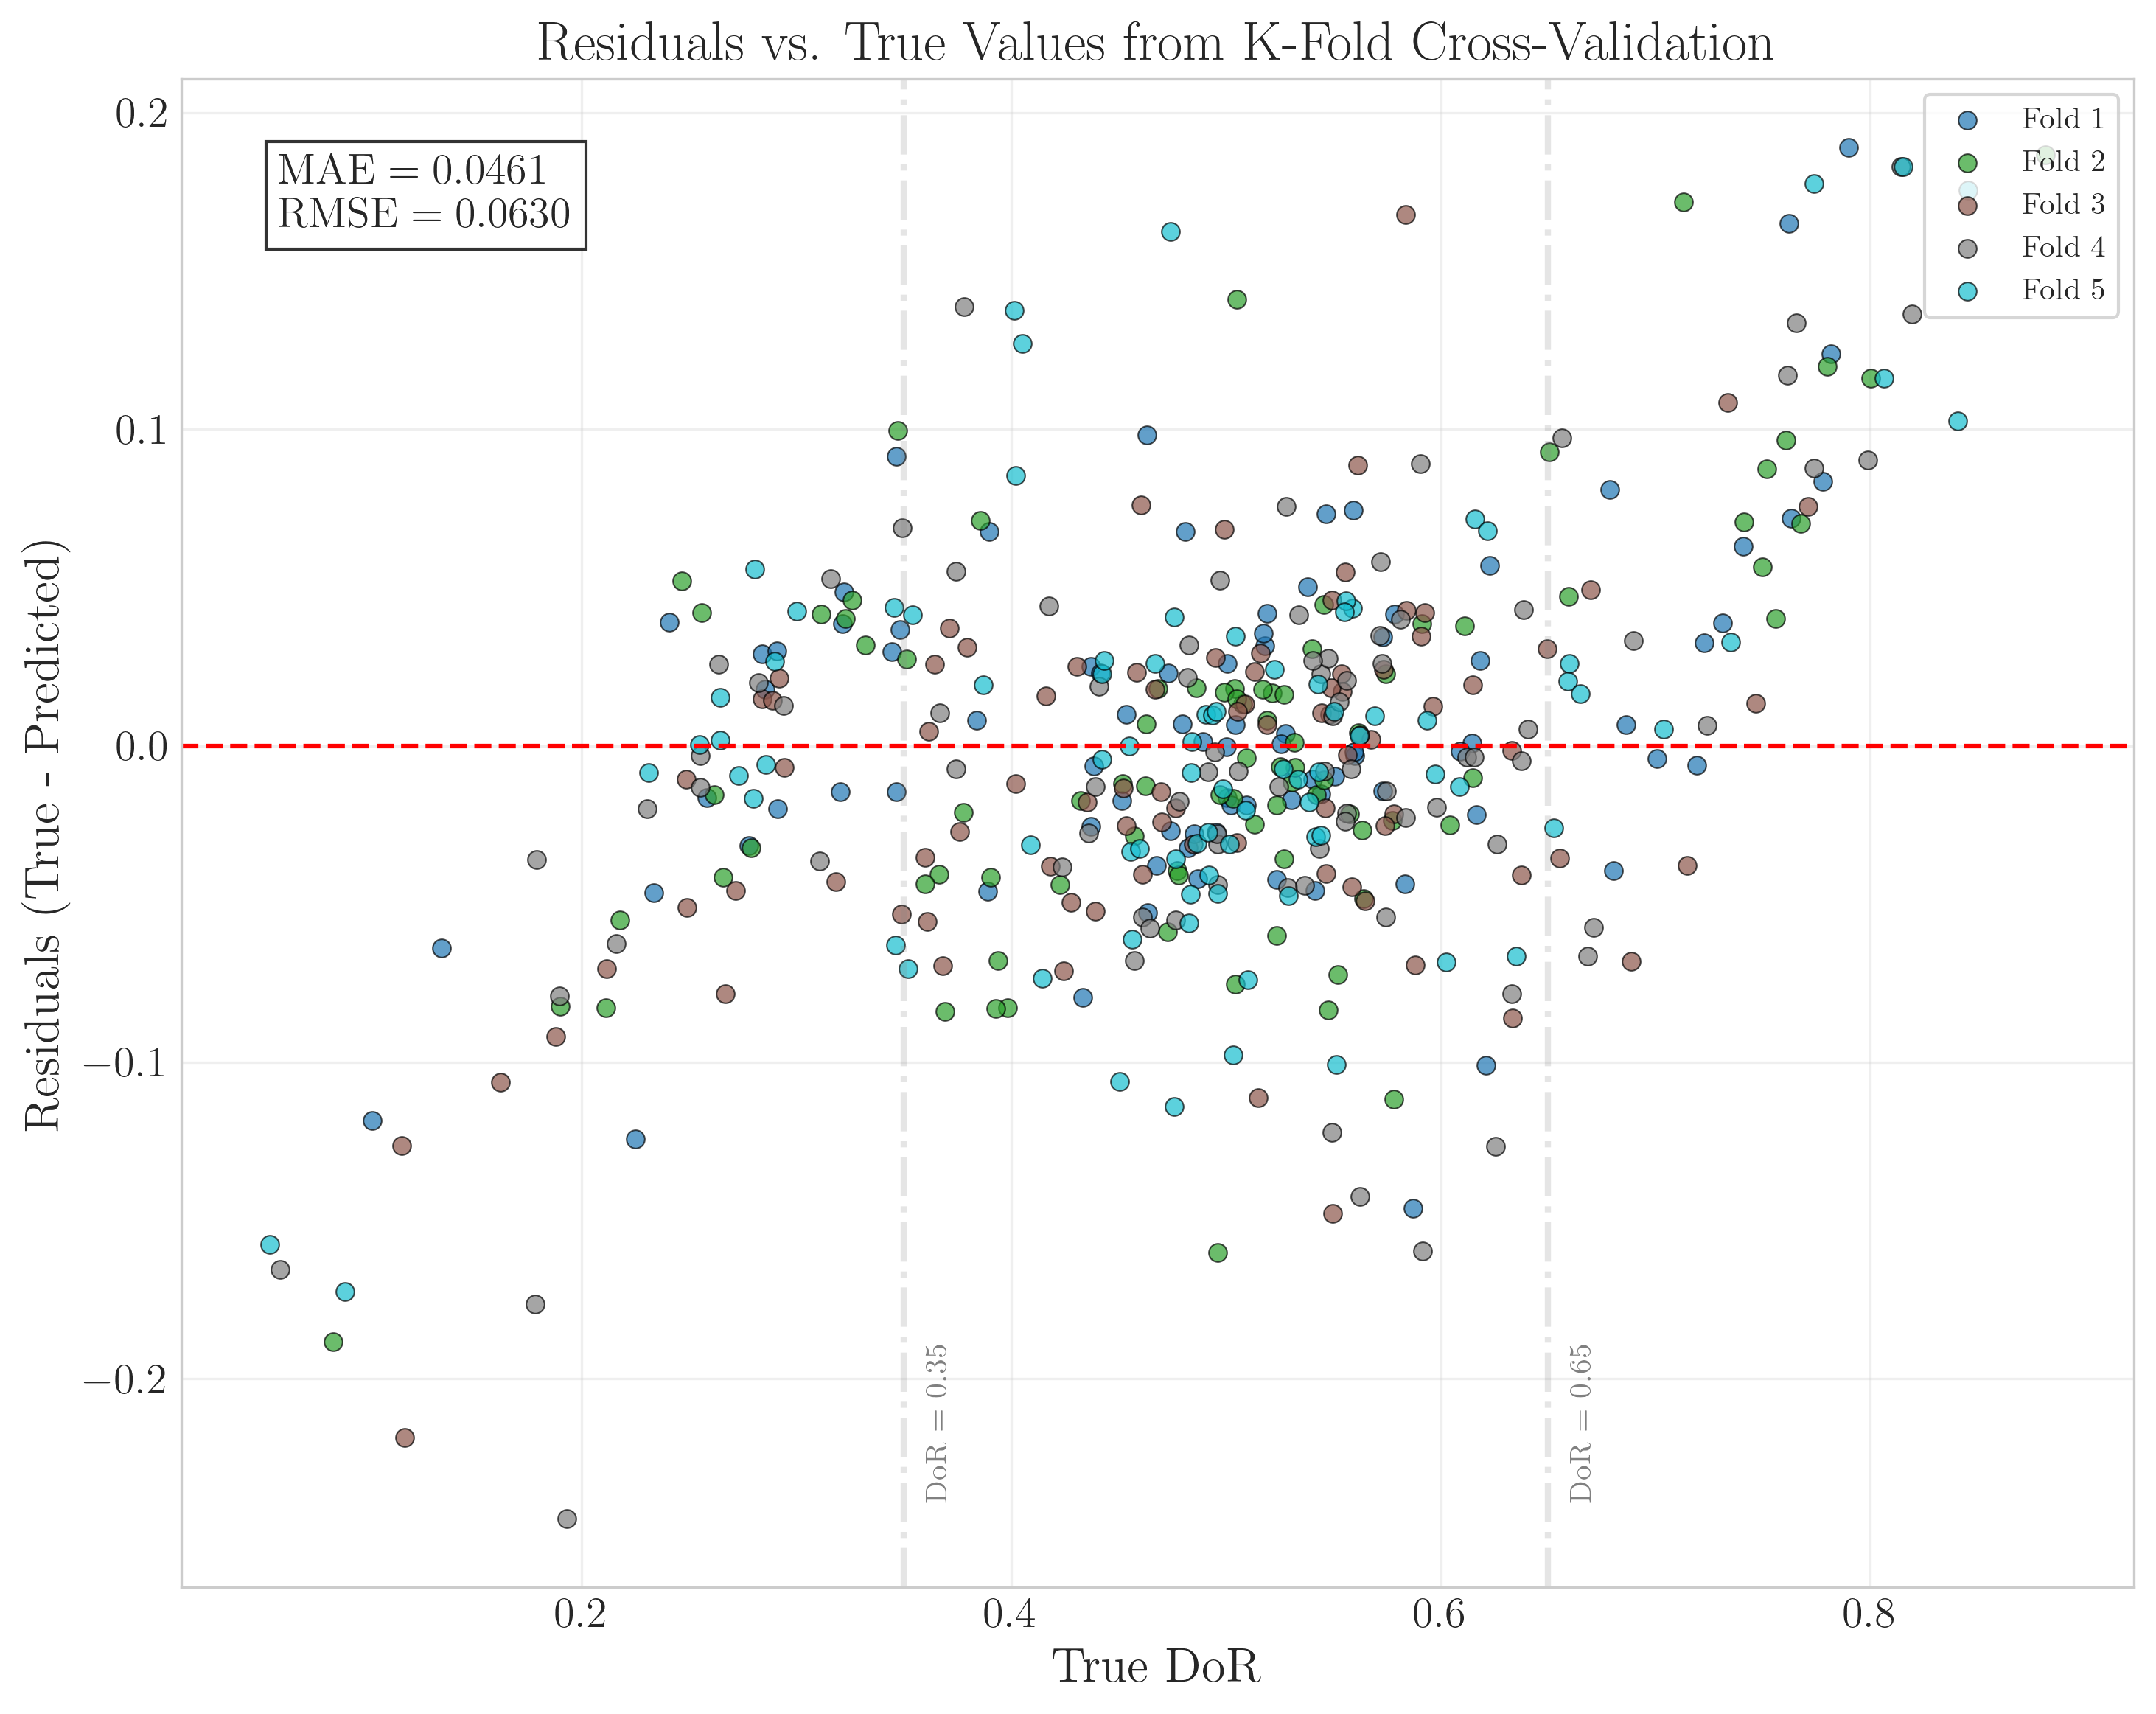

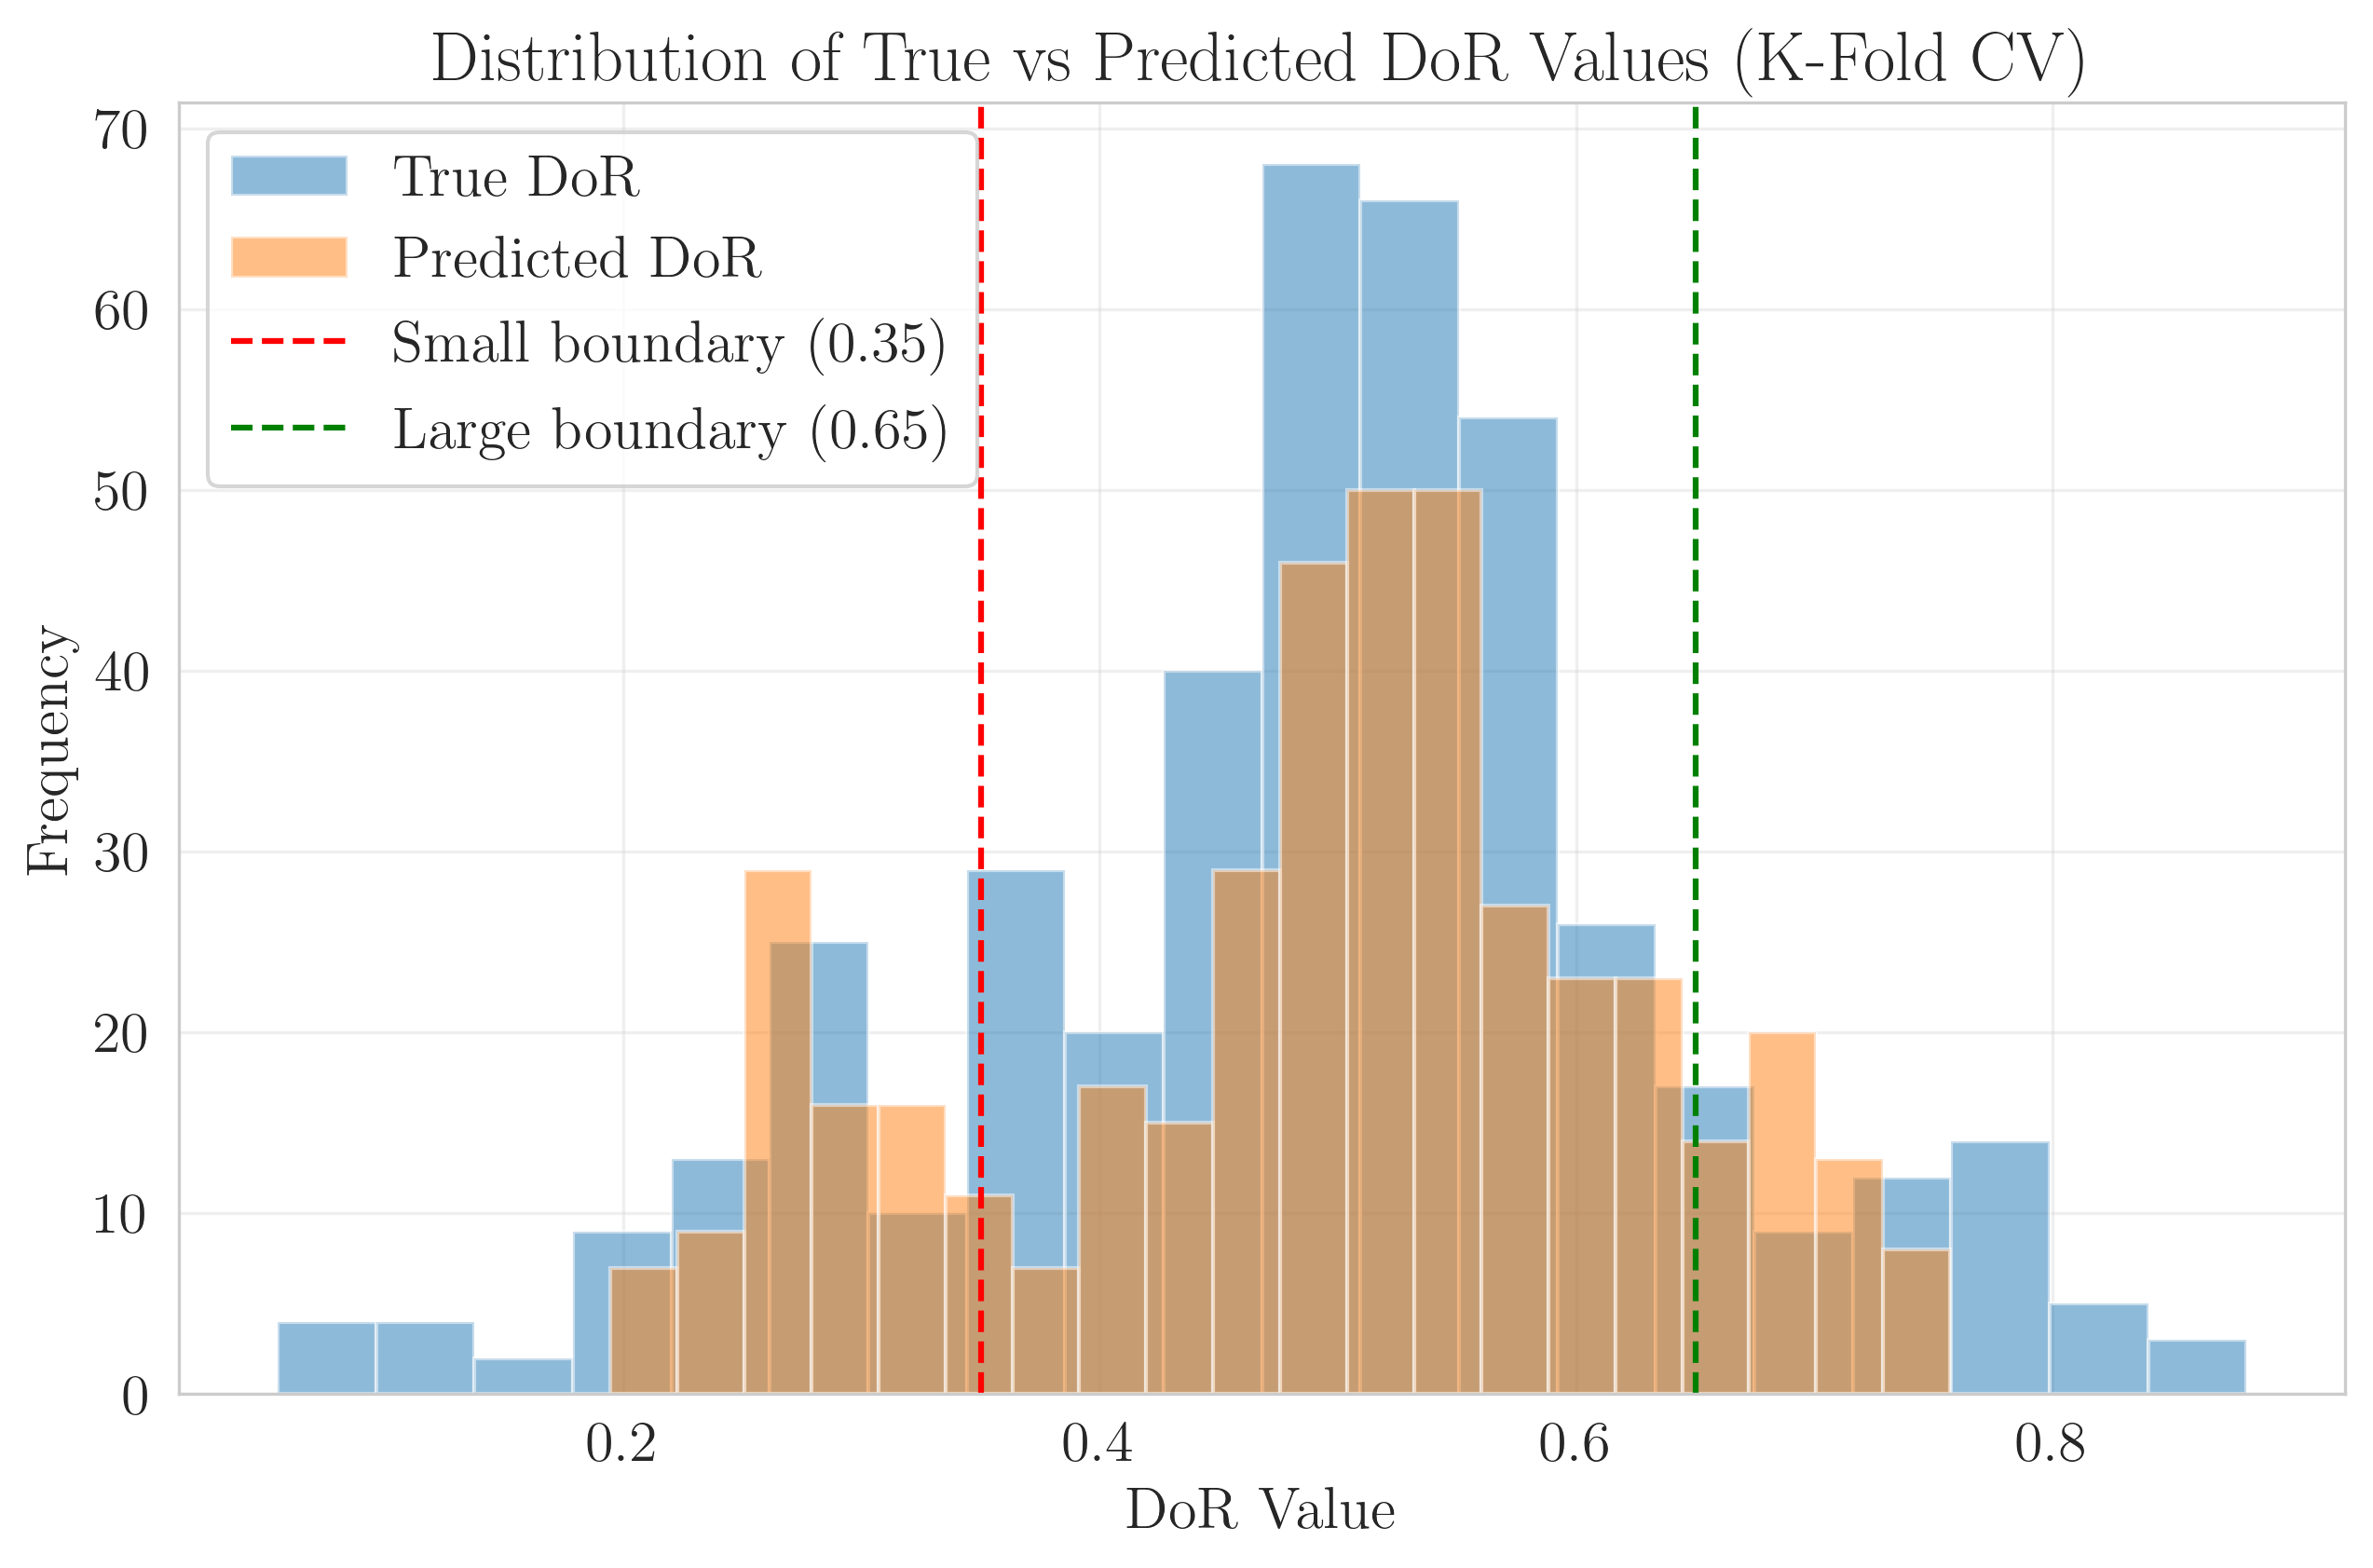

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os

def visualize_kfold_predictions(df, features, target='DoR', n_splits=5, model_params=None, output_path=None):
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Default model parameters if none provided
    if model_params is None:
        seed = 42  # Define a seed for reproducibility
        model_params = {
            'max_depth': 22,
            'max_features': 0.793,
            'max_samples': 0.500,
            'min_samples_leaf': 1,
            'min_samples_split': 4,
            'n_estimators': 460,
            'random_state': seed
        }
    
    X = df[features]
    y = df[target]
    
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=model_params.get('random_state', 42))
    
    # Initialize arrays to store all predictions
    all_true = np.zeros_like(y)
    all_pred = np.zeros_like(y)
    all_residuals = np.zeros_like(y)
    fold_indices = np.zeros_like(y, dtype=int)  # Track which fold each point belongs to
    fold_results = {
        'r2_scores': [], 
        'indices': [], 
        'predictions': [], 
        'true_values': [],
        'true_values_all': y.values
    }
    
    # Define colors for different folds
    fold_colors = plt.cm.tab10(np.linspace(0, 1, n_splits))
    
    # Perform k-fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model and make predictions
        rf_model = RandomForestRegressor(**model_params)
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        
        # Store results for this fold
        r2 = r2_score(y_test, y_pred)
        fold_results['r2_scores'].append(r2)
        fold_results['indices'].append(test_idx)
        fold_results['predictions'].append(y_pred)
        fold_results['true_values'].append(y_test.values)
        
        # Store predictions and residuals at the correct indices
        all_true[test_idx] = y_test
        all_pred[test_idx] = y_pred
        all_residuals[test_idx] = y_test - y_pred
        fold_indices[test_idx] = fold  # Track which fold this point belongs to
        
        print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}")
    
    # Calculate overall R² for all folds combined
    overall_r2 = r2_score(all_true, all_pred)
    mean_fold_r2 = np.mean(fold_results['r2_scores'])
    std_fold_r2 = np.std(fold_results['r2_scores'])
    
    print(f"\nCross-validation results:")
    print(f"Mean fold R²: {mean_fold_r2:.4f} (±{std_fold_r2:.4f})")
    print(f"Overall R² (all predictions): {overall_r2:.4f}")

    # Create figure for visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot each fold with different colors - x=predicted, y=true
    for fold in range(1, n_splits + 1):
        mask = fold_indices == fold
        ax.scatter(all_pred[mask], all_true[mask], alpha=0.7, s=35, 
                   color=fold_colors[fold-1], edgecolors='k', linewidths=0.5,
                   label=f'Fold {fold} (R²: {fold_results["r2_scores"][fold-1]:.4f})')
    
    # Add perfect prediction line
    min_val = min(min(all_true), min(all_pred))
    max_val = max(max(all_true), max(all_pred))
    buffer = (max_val - min_val) * 0.05
    plot_min = min_val - buffer
    plot_max = max_val + buffer
    
    ax.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', 
            label='Perfect prediction', linewidth=1.5)
    
    # Add vertical gray dash-dot lines at predicted DoR values of 0.35 and 0.65
    ax.axvline(x=0.35, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    ax.axvline(x=0.65, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    
    # Add small gray labels next to the lines
    ax.text(0.36, plot_max - buffer, 'DoR = 0.35', 
            style='italic', color='gray', fontsize=10, va='top', rotation=90)
    ax.text(0.66, plot_max - buffer, 'DoR = 0.65', 
            style='italic', color='gray', fontsize=10, va='top', rotation=90)
    
    # Customize plot - SWAPPED AXES
    ax.set_ylabel(f'True {target}', fontsize=25)
    ax.set_xlabel(f'Predicted {target}', fontsize=25)
    ax.set_ylim(plot_min, plot_max)
    ax.set_xlim(plot_min, plot_max)
    
    # Add textbox with performance metrics
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
    textstr = '\n'.join((
        r'$\mathrm{Overall}\ R^2 = %.4f$' % (overall_r2,),
        r'$\mathrm{Mean}\ R^2 = %.4f\ (\pm%.4f)$' % (mean_fold_r2, std_fold_r2),
    ))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Add legend
    ax.legend(loc='lower right', fontsize=10)
    
    # Add grid and styling
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax.minorticks_on()
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    
    # Create a consolidated DataFrame with all k-fold predictions
    # This will make it easier to use for downstream tasks
    all_indices = []
    all_predictions = []
    
    for i in range(len(fold_results['indices'])):
        all_indices.extend(fold_results['indices'][i])
        all_predictions.extend(fold_results['predictions'][i])
    
    # Create DataFrame with predictions
    pred_df = pd.DataFrame({
        'index': all_indices,
        'predicted_DoR': all_predictions
    })
    
    # Sort by index to match the original DataFrame order
    pred_df = pred_df.sort_values('index').reset_index(drop=True)
    
    # Add consolidated predictions to fold_results
    fold_results['pred_df'] = pred_df
    fold_results['all_true'] = all_true
    fold_results['all_pred'] = all_pred
    fold_results['all_residuals'] = all_residuals
    fold_results['fold_indices'] = fold_indices
    
    return fig, fold_results

def plot_residuals_from_kfold(fold_results, target='DoR', output_path=None):

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Extract data from fold_results
    all_true = fold_results['all_true']
    all_residuals = fold_results['all_residuals']
    fold_indices = fold_results['fold_indices']
    
    # Create figure for the residuals vs true values plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define colors for different folds
    n_folds = len(set(fold_indices)) - (1 if 0 in fold_indices else 0)
    fold_colors = plt.cm.tab10(np.linspace(0, 1, n_folds))
    
    # Plot residuals vs true values for each fold with different colors
    for fold in range(1, n_folds + 1):
        mask = fold_indices == fold
        ax.scatter(all_true[mask], all_residuals[mask], alpha=0.7, s=35, 
                  color=fold_colors[fold-1], edgecolors='k', linewidths=0.5,
                  label=f'Fold {fold}')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    
    # Calculate metrics
    mae = mean_absolute_error(all_true, all_true - all_residuals)
    rmse = np.sqrt(mean_squared_error(all_true, all_true - all_residuals))
    
    # Add overall metrics in a textbox
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')
    textstr = '\n'.join((
        r'$\mathrm{MAE} = %.4f$' % (mae,),
        r'$\mathrm{RMSE} = %.4f$' % (rmse,)
    ))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props, horizontalalignment='left')
    
    # Add vertical lines at DoR boundaries
    ax.axvline(x=0.35, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    ax.axvline(x=0.65, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    
    # Add small gray labels next to the lines
    ax.text(0.36, ax.get_ylim()[0] * 0.9, 'DoR = 0.35', 
            style='italic', color='gray', fontsize=10, va='bottom', rotation=90)
    ax.text(0.66, ax.get_ylim()[0] * 0.9, 'DoR = 0.65', 
            style='italic', color='gray', fontsize=10, va='bottom', rotation=90)
    
    ax.set_xlabel(f'True {target}', fontsize=16)
    ax.set_ylabel('Residuals (True - Predicted)', fontsize=16)
    ax.set_title('Residuals vs. True Values from K-Fold Cross-Validation', fontsize=18)
    
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax.minorticks_on()
    
    # Add legend
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    
    return fig

def export_dor_groups_from_kfold(df, pred_df, output_path, small_boundary=0.35, large_boundary=0.65, csv_name='DoR_Groups_KFold.csv'):
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [
        f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
        for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])
    ]
    
    # Get predicted DoR values from k-fold cross-validation
    # Make sure indices are properly aligned
    dor_pred = np.zeros(len(df))
    for idx, pred_val in zip(pred_df['index'], pred_df['predicted_DoR']):
        dor_pred[idx] = pred_val
    
    # Create labels based on predicted DoR
    labels = pd.Series(1, index=df.index)  # middle group
    labels[dor_pred <= small_boundary] = 0  # small group
    labels[dor_pred >= large_boundary] = 2  # large group
    
    # Save results
    results_df = pd.DataFrame({
        'SDSS_ID': sdss_ids, 
        'Cluster': labels,
        'True_DoR': df['DoR'],
        'Predicted_DoR': dor_pred
    })
    
    filename = os.path.join(output_path, csv_name)
    results_df.to_csv(filename, index=False)
    
    print(f"\nSaved DoR groups to {filename}")
    print("Group sizes (based on predicted DoR):")
    print(f"Predicted DoR <= {small_boundary}: {sum(labels == 0)}")
    print(f"{small_boundary} < Predicted DoR < {large_boundary}: {sum(labels == 1)}")
    print(f"Predicted DoR >= {large_boundary}: {sum(labels == 2)}")
    
    # Plot histogram of predicted vs true DoR
    plt.figure(figsize=(10, 6))
    plt.hist(df['DoR'], bins=20, alpha=0.5, label='True DoR')
    plt.hist(dor_pred, bins=20, alpha=0.5, label='Predicted DoR')
    plt.axvline(small_boundary, color='red', linestyle='--', label=f'Small boundary ({small_boundary})')
    plt.axvline(large_boundary, color='green', linestyle='--', label=f'Large boundary ({large_boundary})')
    plt.xlabel('DoR Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of True vs Predicted DoR Values (K-Fold CV)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save histogram
    hist_filename = os.path.join(output_path, f'distribution_{csv_name.replace(".csv", ".png")}')
    plt.savefig(hist_filename, bbox_inches='tight')
    plt.show()
    
    return results_df

def run_kfold_prediction_and_export(df, features, target='DoR', n_splits=5, model_params=None, 
                                   small_boundary=0.35, large_boundary=0.65,
                                   output_path='../data/cluster_results', 
                                   figure_name='kfold_predictions.png',
                                   residuals_figure_name='kfold_residuals.png',
                                   csv_name='kfold_dor_groups.csv'):
    os.makedirs(output_path, exist_ok=True)
    
    # Step 1: Run k-fold cross-validation and visualize predictions
    figure_path = os.path.join(output_path, figure_name)
    fig, results = visualize_kfold_predictions(
        df=df,
        features=features,
        target=target,
        n_splits=n_splits,
        model_params=model_params,
        output_path=figure_path
    )
    
    # Step 2: Create residuals plot
    residuals_path = os.path.join(output_path, residuals_figure_name)
    residuals_fig = plot_residuals_from_kfold(
        fold_results=results,
        target=target,
        output_path=residuals_path
    )
    
    # Step 3: Extract the prediction DataFrame from results
    pred_df = results['pred_df']
    
    # Step 4: Export DoR groups based on k-fold predictions
    results_df = export_dor_groups_from_kfold(
        df=df,
        pred_df=pred_df,
        small_boundary=small_boundary,
        large_boundary=large_boundary,
        output_path=output_path,
        csv_name=csv_name
    )
    
    return fig, residuals_fig, results, results_df


FEATURES = [
    'MgFe', 
    '[M/H]_mean_mass', 
    '[M/H]_err_mass',
    'velDisp_ppxf_res', 
    'velDisp_ppxf_err_res',
    'age_mean_mass', 
    'age_err_mass', 
    'meanRad_r', 
    'logM*',
]

MODEL_PARAMS = {
    'max_depth': 20,
    'max_features': 0.8,
    'max_samples': 0.500,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 450,
    'random_state': 1
}

# Read your data
df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')

# Run the entire workflow
fig, residuals_fig, results, results_df = run_kfold_prediction_and_export(
    df=df,
    features=FEATURES,
    target='DoR',
    n_splits=5,
    model_params=MODEL_PARAMS,
    small_boundary=0.35,
    large_boundary=0.65,
    output_path='../data/cluster_results',
    figure_name='regression_performance.png',
    residuals_figure_name='residuals.png',
    csv_name='regression_clusters.csv'
)
